**Name:** Sayed Hesam Alavian\


In this notebook, we will be building and training LSTM and GRU to predict the stock market. You do not allow to use TensorFlow and Keras libraries.

## 1. Libraries and settings

In [52]:
# Import libraries 
# Notice that it is important that which libraries you use, so you should import
# libraries just here in your code

from copy import deepcopy

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

## 2. Load data

In [53]:
# Read data 
url = 'https://drive.google.com/u/0/uc?id=1JRBZfsG6UgWG3AlxwmC1q6hhd1-1dybm&export=download'
df = pd.read_csv(url)
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.NVDA,D,20101004,0,11.24,11.430,11.01,11.23,18184874
1,US1.NVDA,D,20101005,0,11.48,11.500,11.29,11.32,18266877
2,US1.NVDA,D,20101006,0,11.32,11.370,10.67,10.78,25753399
3,US1.NVDA,D,20101007,0,10.82,10.840,10.38,10.70,18732301
4,US1.NVDA,D,20101008,0,10.65,10.950,10.51,10.86,16998198
...,...,...,...,...,...,...,...,...,...
2762,US1.NVDA,D,20210927,0,217.16,217.750,213.28,216.57,625939
2763,US1.NVDA,D,20210928,0,212.01,214.030,206.51,207.02,835341
2764,US1.NVDA,D,20210929,0,209.33,210.160,204.68,205.22,606902
2765,US1.NVDA,D,20210930,0,207.89,210.650,206.89,207.12,537697


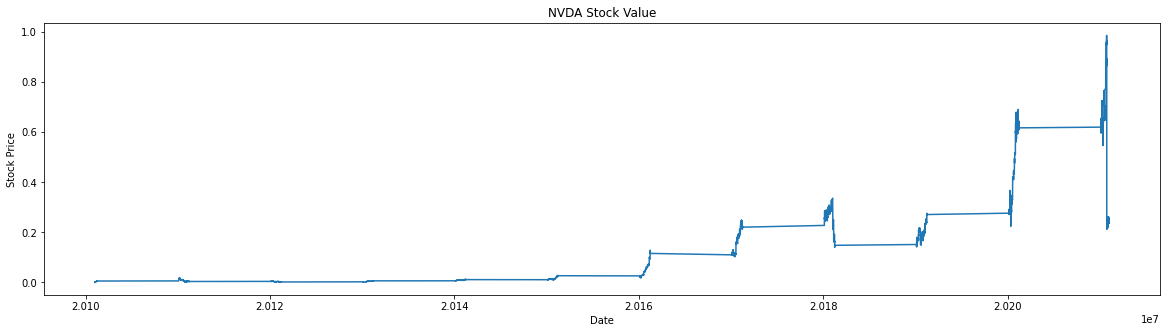

In [54]:
# Plot close prices ("<CLOSE>") based on dates ("<DATE>") 
##################### Normalize data ####################
min_close = df['<CLOSE>'].min()
max_close = df['<CLOSE>'].max()
df['<CLOSE>'] -= min_close
df['<CLOSE>'] /= max_close
#####################
plt.figure(figsize=(20,5))
plt.plot(df['<DATE>'], df['<CLOSE>'])
plt.title('NVDA Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

minmax scale

In [55]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2166, 59, 9)
y_train.shape =  (2166, 9)
x_test.shape =  (541, 59, 9)
y_test.shape =  (541, 9)


In [56]:
################# Reshape ################
x_train_7 = x_train[:, :, 7].reshape((x_train[:, :, 7].shape[0], x_train[:, :, 7].shape[1], 1)).astype(np.float32)
y_train_7 = y_train[:, 7].reshape((y_train[:, 7].shape[0], 1)).astype(np.float32)
x_test_7 = x_test[:, :, 7].reshape((x_test[:, :, 7].shape[0], x_test[:, :, 7].shape[1], 1)).astype(np.float32)
y_test_7 = y_test[:, 7].reshape((y_test[:, 7].shape[0], 1)).astype(np.float32)
print('x_train_7.shape = ',x_train_7.shape)
print('y_train_7.shape = ',y_train_7.shape)
print('x_test_7.shape = ',x_test_7.shape)
print('y_test_7.shape = ',y_test_7.shape)

x_train_7.shape =  (2166, 59, 1)
y_train_7.shape =  (2166, 1)
x_test_7.shape =  (541, 59, 1)
y_test_7.shape =  (541, 1)


In [57]:
############## Dataloaders ################
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, labels):
        'Initialization'
        self.labels = labels
        self.x = x
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        x = self.x[index]
        y = self.labels[index]

        return x, y


In [58]:
dataset_train = Dataset(x_train_7, y_train_7)
dataset_test = Dataset(x_test_7, y_test_7)

In [59]:
batch_size = 50

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [60]:
def test():
    i_loader_train = iter(loader_train)
    print()
    inputs, labels = next(i_loader_train)
    print(inputs.shape, labels.shape)

test()


torch.Size([50, 59, 1]) torch.Size([50, 1])


In [61]:
# Build the structure of models
# we can change these parameters to get better result
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

In [62]:
# Build model

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        ##################
        output_lstm, (hn, cn) = self.lstm(x)
        output_lin = self.fc(output_lstm)
        return output_lin
        ##################


class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        ##################
        output_gru, hn = self.gru(x)
        output_lin = self.fc(output_gru)
        return output_lin
        ##################
        

In [63]:
################## Train loop 
class TrainLoop:
    def __init__(self, model, data_loader, loss_fn, optimizer):
        self.model = model
        self.data_loader = data_loader
        self.i_data_loader = iter(self.data_loader)
        self.loss_fn = loss_fn 
        self.optimizer = optimizer
        self.loss_hist = []
        self.accuracy_hist = []
        
    def loop(self, n_batches, verbose=True):
        total_loss = 0

        for _ in range(n_batches):
            try:
                inputs, labels = next(self.i_data_loader)
            except StopIteration:
                self.i_data_loader = iter(self.data_loader)
                inputs, labels = next(self.i_data_loader)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            output_single = outputs[:, -1, 0]
            output_single = torch.reshape(output_single, (output_single.shape[0], 1))
            
            loss = self.loss_fn(output_single, labels)
            loss.requres_grad = True
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_batch_loss = total_loss / n_batches
        
        self.loss_hist.append(avg_batch_loss)

        if verbose:
            print("    training loss:", avg_batch_loss)

        return avg_batch_loss

In [64]:
##########  Test loop
class TestLoop:
    def __init__(self, model, data_loader, loss_fn):
        self.model = model
        self.data_loader = data_loader
        self.i_data_loader = iter(data_loader)
        self.loss_fn = loss_fn
        self.loss_hist = []
        self.accuracy_hist = []

    def loop(self, n_batches, verbose=True):

        total_loss = 0
        total_accuracy = 0

        for _ in range(n_batches):
            try:
                inputs, labels = next(self.i_data_loader)
            except StopIteration:
                self.i_data_loader = iter(self.data_loader)
                inputs, labels = next(self.i_data_loader)

            with torch.no_grad():
                outputs = self.model(inputs)

            outputs = self.model(inputs)
            output_single = outputs[:, -1, 0]
            output_single = torch.reshape(output_single, (output_single.shape[0], 1))
            
            loss = self.loss_fn(output_single, labels)
            accuracy = 0

            total_loss += loss
            total_accuracy += 0
        
        avg_batch_loss = total_loss / n_batches
        avg_batch_accuracy = - total_accuracy / n_batches
        self.loss_hist.append(avg_batch_loss)
        self.accuracy_hist.append(avg_batch_accuracy)

        if verbose:
            print(f"   test loss: {avg_batch_loss}")

        return avg_batch_loss, avg_batch_accuracy

In [65]:
# Train LSTM

#####################

# your code

epochs_lstm = 100
model_lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim)
model_best_lstm = None

loss_fn_lstm = nn.MSELoss()
learning_rate_lstm = 0.005
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate_lstm)

train_looper_lstm = TrainLoop(model_lstm, loader_train, loss_fn_lstm, optimizer_lstm)
test_looper_lstm = TestLoop(model_lstm, loader_test, loss_fn_lstm)
best_loss_lstm = 0

for epoch in tqdm(range(epochs_lstm)):
    print(f"Epoch {epoch+1}:")
    train_looper_lstm.loop(n_batches=40)
    loss, _ = test_looper_lstm.loop(n_batches=5)
    if loss < best_loss_lstm:
        best_loss_lstm = loss
        model_best_lstm = deepcopy(model_lstm)

#####################

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:
    training loss: 0.003894794818916125
   test loss: 0.009449145756661892
Epoch 2:
    training loss: 0.00010983466499965288
   test loss: 0.012690804898738861
Epoch 3:
    training loss: 7.720373009760806e-05
   test loss: 0.011017999611794949
Epoch 4:
    training loss: 5.724144015175625e-05
   test loss: 0.012174234725534916
Epoch 5:
    training loss: 5.097114278669323e-05
   test loss: 0.01171211339533329
Epoch 6:
    training loss: 5.945901655195485e-05
   test loss: 0.010317877866327763
Epoch 7:
    training loss: 5.9567733069343375e-05
   test loss: 0.006624413188546896
Epoch 8:
    training loss: 5.604167251931358e-05
   test loss: 0.005023159086704254
Epoch 9:
    training loss: 6.867238171253121e-05
   test loss: 0.008516235277056694
Epoch 10:
    training loss: 4.454079869447014e-05
   test loss: 0.00556500069797039
Epoch 11:
    training loss: 5.447084670322511e-05
   test loss: 0.004812358412891626
Epoch 12:
    training loss: 4.455809294086066e-05
   test loss:

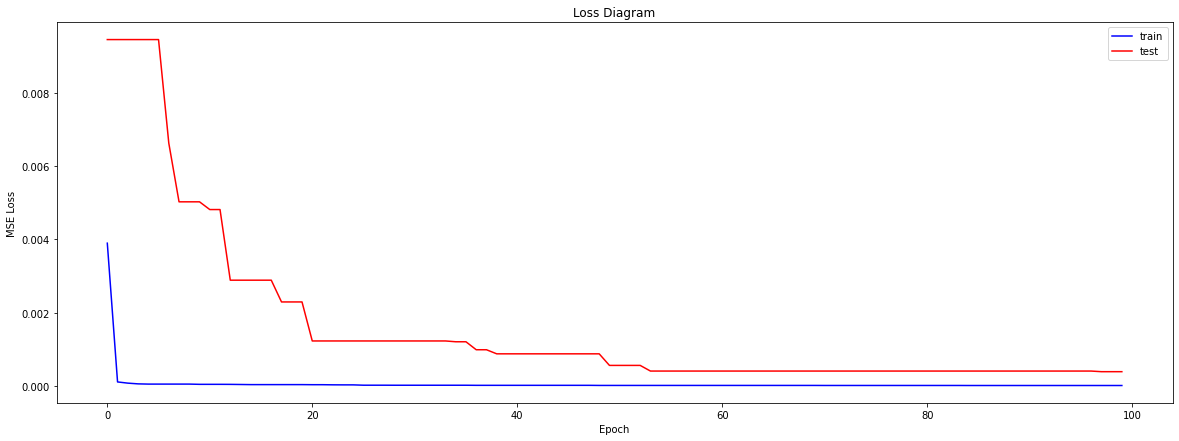

In [66]:
# Plot loss based on epochs

#####################

# your code
train_loss_hist_lstm = []
for item in train_looper_lstm.loss_hist:
    if len(train_loss_hist_lstm) == 0 or item < train_loss_hist_lstm[-1]:
        train_loss_hist_lstm.append(item)
    else:
        train_loss_hist_lstm.append(train_loss_hist_lstm[-1])

test_loss_hist_lstm = []
for item in test_looper_lstm.loss_hist:
    if len(test_loss_hist_lstm) == 0 or item < test_loss_hist_lstm[-1]:
        test_loss_hist_lstm.append(item)
    else:
        test_loss_hist_lstm.append(test_loss_hist_lstm[-1])

plt.figure(figsize=(20,7))
plt.plot(train_loss_hist_lstm, label="train", color='b')
plt.plot(test_loss_hist_lstm, label="test", color='r')
plt.title('Loss Diagram')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

#####################

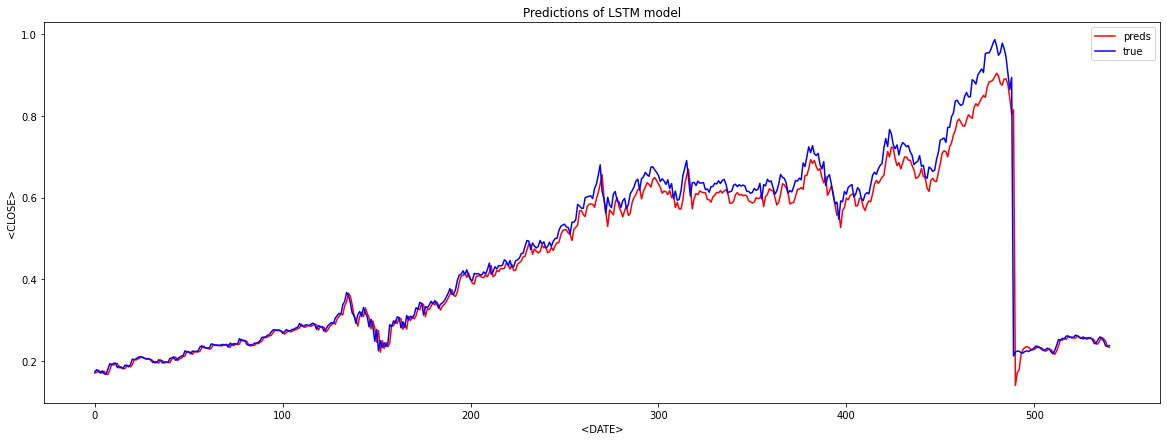

In [67]:
# make predictions

#####################
# your code
preds_lstm = []
true_values = []

for index, item in enumerate(x_test_7):
    x = item.reshape(1, *item.shape)
    with torch.no_grad():
        outputs = model_lstm(torch.from_numpy(x))
    output_single = outputs[0, -1, 0]
    preds_lstm.append(output_single)
    true_values.append(y_test_7[index, 0])

plt.figure(figsize=(20,7))
plt.plot(preds_lstm, label="preds", color='r')
plt.plot(true_values, label="true", color='b')
plt.title('Predictions of LSTM model')
plt.xlabel('<DATE>')
plt.ylabel('<CLOSE>')
plt.legend()
plt.show()
#####################



In [68]:

# Calculate root mean squared error

#####################
# your code

total_loss = 0

for index, item in enumerate(x_test_7):
    x = item.reshape(1, *item.shape)
    with torch.no_grad():
        outputs = model_lstm(torch.from_numpy(x))
    
    output_single = outputs[0, -1, 0]
    total_loss += (output_single - y_test_7[index, 0]) ** 2
    
rmse_lstm = (total_loss/index)**.5
print(f"RMSE of LSTM on Test Data: {rmse_lstm}")
#####################

RMSE of LSTM on Test Data: 0.03816872090101242


In [69]:
# Train GRU model

#####################
# your code

epochs_gru = 100
model_gru = GRU(input_dim, hidden_dim, num_layers, output_dim)
model_best_gru = None

loss_fn_gru = nn.MSELoss()
learning_rate_gru = 0.005
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=learning_rate_gru)

train_looper_gru = TrainLoop(model_gru, loader_train, loss_fn_gru, optimizer_gru)
test_looper_gru = TestLoop(model_gru, loader_test, loss_fn_gru)
best_loss_gru = 0

for epoch in tqdm(range(epochs_gru)):
    print(f"Epoch {epoch+1}:")
    train_looper_gru.loop(n_batches=40)
    loss, _ = test_looper_gru.loop(n_batches=5)
    if loss < best_loss_gru:
        best_loss_gru = loss
        model_best_gru = deepcopy(model_gru)

#####################

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1:
    training loss: 0.0047020496602272034
   test loss: 0.006662496365606785
Epoch 2:
    training loss: 6.228506306342752e-05
   test loss: 0.0028838193975389004
Epoch 3:
    training loss: 2.1756216312951437e-05
   test loss: 0.0010799526935443282
Epoch 4:
    training loss: 1.9128496865050694e-05
   test loss: 0.0011389737483114004
Epoch 5:
    training loss: 2.3037605473064104e-05
   test loss: 0.0027756611816585064
Epoch 6:
    training loss: 1.57902726868997e-05
   test loss: 0.002549032913520932
Epoch 7:
    training loss: 1.9976323079617943e-05
   test loss: 0.0010227607563138008
Epoch 8:
    training loss: 1.852919979228318e-05
   test loss: 0.001042830408550799
Epoch 9:
    training loss: 1.9270625364242734e-05
   test loss: 0.0026292516849935055
Epoch 10:
    training loss: 1.6256024150607117e-05
   test loss: 0.00042818402289412916
Epoch 11:
    training loss: 2.1170033255657474e-05
   test loss: 0.002916876692324877
Epoch 12:
    training loss: 2.0404660870099178e-

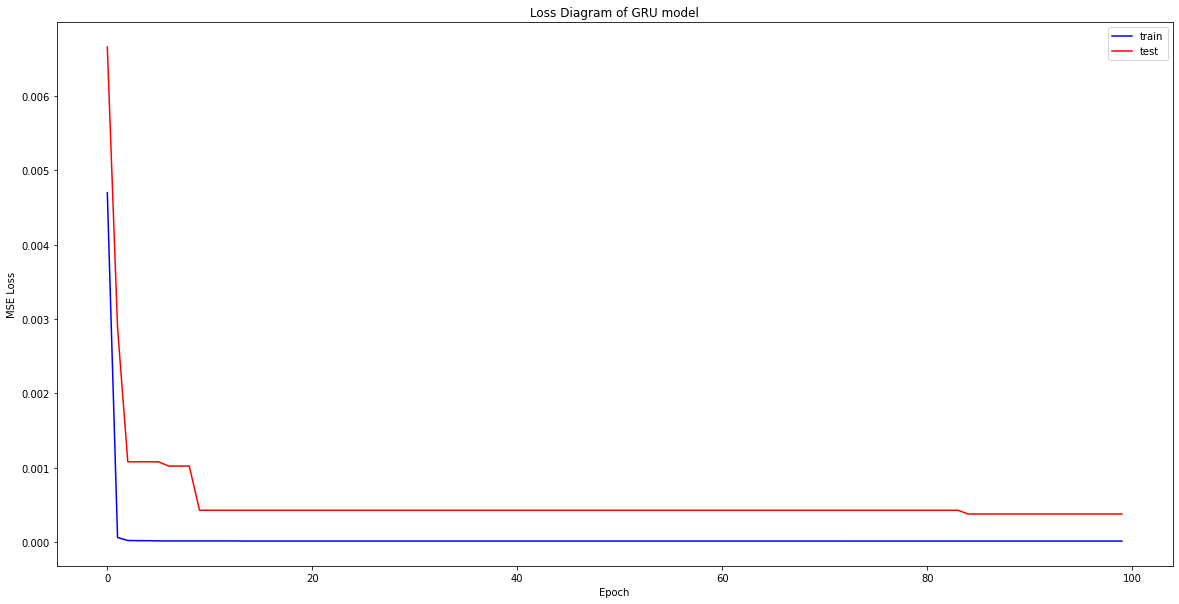

In [70]:
# Plot loss based on epochs

#####################
# your code

train_loss_hist_gru = []
for item in train_looper_gru.loss_hist:
    if len(train_loss_hist_gru) == 0 or item < train_loss_hist_gru[-1]:
        train_loss_hist_gru.append(item)
    else:
        train_loss_hist_gru.append(train_loss_hist_gru[-1])

test_loss_hist_gru = []
for item in test_looper_gru.loss_hist:
    if len(test_loss_hist_gru) == 0 or item < test_loss_hist_gru[-1]:
        test_loss_hist_gru.append(item)
    else:
        test_loss_hist_gru.append(test_loss_hist_gru[-1])

plt.figure(figsize=(20,10))
plt.plot(train_loss_hist_gru, label="train", color='b')
plt.plot(test_loss_hist_gru, label="test", color='r')
plt.title('Loss Diagram of GRU model')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

#####################

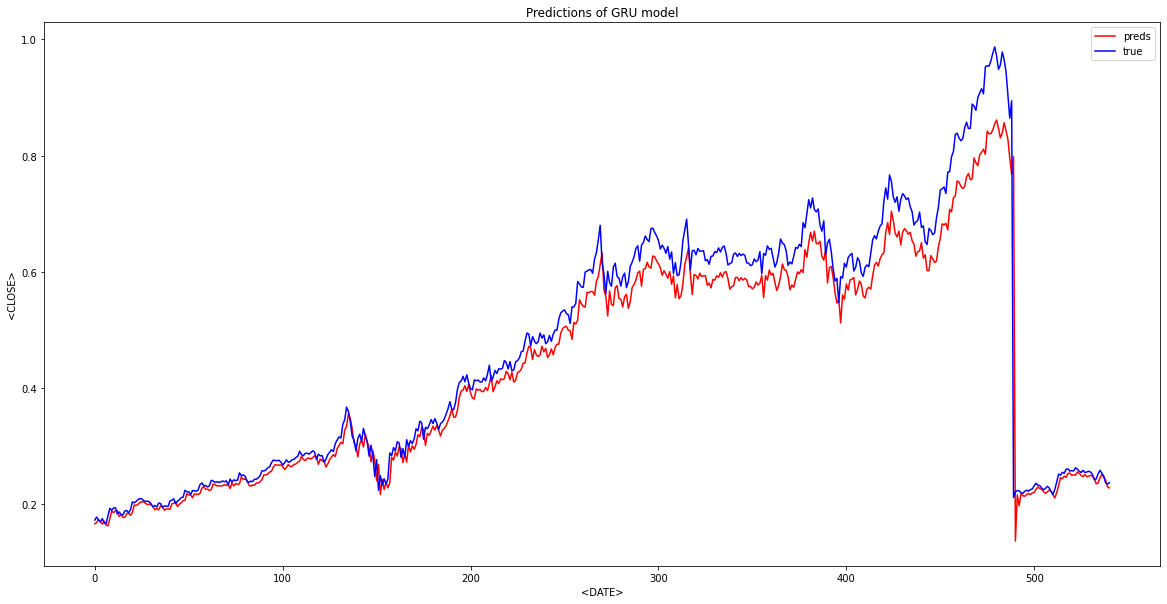

In [71]:
# make predictions

#####################
# your code

preds_gru = []
true_values = []

for index, item in enumerate(x_test_7):
    x = item.reshape(1, *item.shape)
    with torch.no_grad():
        outputs = model_gru(torch.from_numpy(x))
    output_single = outputs[0, -1, 0]
    preds_gru.append(output_single)
    true_values.append(y_test_7[index, 0])

plt.figure(figsize=(20,10))
plt.plot(preds_gru, label="preds", color='r')
plt.plot(true_values, label="true", color='b')
plt.title('Predictions of GRU model')
plt.xlabel('<DATE>')
plt.ylabel('<CLOSE>')
plt.legend()
plt.show()
#####################

In [72]:
# Calculate root mean squared error

#####################
# your code

total_loss = 0

for index, item in enumerate(x_test_7):
    x = item.reshape(1, *item.shape)
    with torch.no_grad():
        outputs = model_gru(torch.from_numpy(x))
    
    output_single = outputs[0, -1, 0]
    total_loss += (output_single - y_test_7[index, 0]) ** 2
    
rmse_gru = (total_loss/index)**.5
print(f"RMSE of GRU on Test Data: {rmse_gru}")
#####################

RMSE of GRU on Test Data: 0.04885849356651306


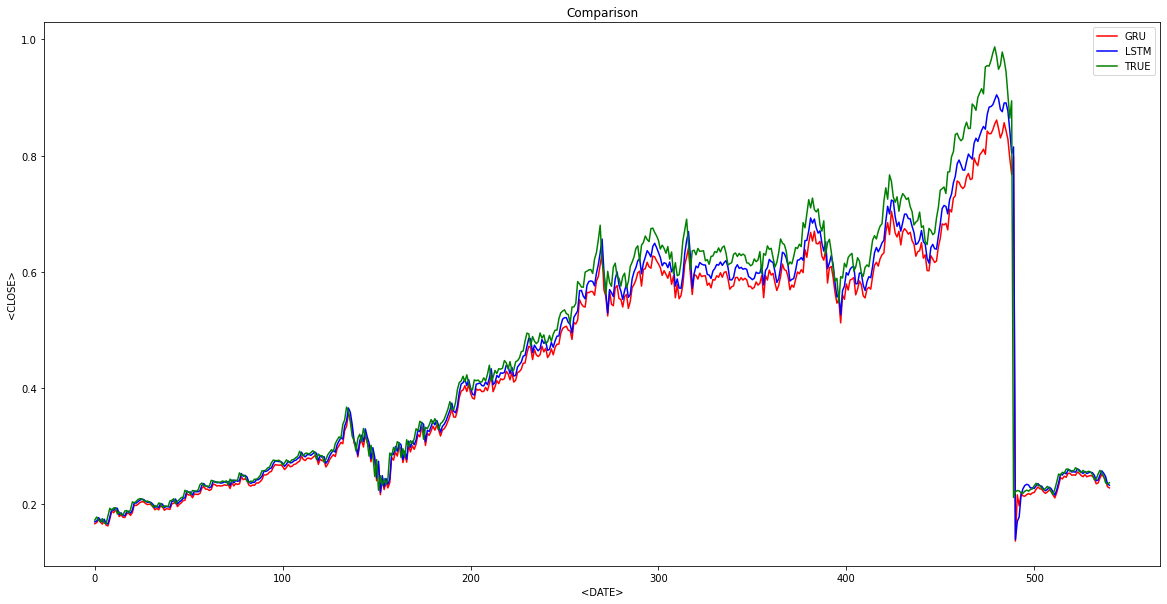

In [73]:
# Visualising the prediction results and compare LSTM and GRU models

#####################
# your code

plt.figure(figsize=(20,10))
plt.plot(preds_gru, label="GRU", color='r')
plt.plot(preds_lstm, label="LSTM", color='b')
plt.plot(true_values, label="TRUE", color='g')
plt.title('Comparison')
plt.xlabel('<DATE>')
plt.ylabel('<CLOSE>')
plt.legend()
plt.show()
#####################

**Bonus (5%)** \
try denoising techniques and train models again after denoising the prices. Then compare the results with previous step and explain how much improvment you can make by denoising data. 